In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
import glob
import os
import sys
import miepython
import numpy as np
import dask
from dask_jobqueue import SLURMCluster
from dask.distributed import Client, progress
import matplotlib.pyplot as plt
from re import split
from pytmatrix import tmatrix, tmatrix_aux, refractive
from pytmatrix.radar import radar_xsect, refl
from pytmatrix.scatter import sca_xsect, ext_xsect
from labellines import labelLine, labelLines
from scipy.special import gamma
import warnings
warnings.filterwarnings('ignore')
sys.path.insert(1, f"{os.path.abspath(os.path.join(os.path.abspath(''), '../'))}")
from src.utils import get_pars_from_ini

location = split(', |_|-|!', os.popen('hostname').read())[0].replace("\n", "")
path_data = get_pars_from_ini(file_name='loc')[location]['path_data']


/data/keeling/a/alfonso8/miniconda3/envs/camp2ex_proj/lib/python3.9/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [2]:
def _scatterer(d, ar, wlg, m, angle=180.0, rt=tmatrix.Scatterer.RADIUS_MAXIMUM):
    """
    Function that computes the scatterer object using pytmatrix package
    :param d: diameter in mm
    :param ar:  axis ratio
    :param wlg: wavelength in mm
    :param rt: maximum radius in mm
    :return: list of scatterers objects
    """
    return tmatrix.Scatterer(radius=d / 2., wavelength=wlg, m=m, axis_ratio=1.0 / ar,
                             phi=angle, radius_type=rt, ndgs=10)


def get_phase(x):
    return x.get_Z()[0, 0]


def phase_dask(d, wl="Ku", temp=0, m=None, _dask=False):
    if wl == "Ku":
        wlg = tmatrix_aux.wl_Ku
        if m is None:
            if temp == 0:
                m = refractive.m_w_0C[tmatrix_aux.wl_Ku]
            elif temp == 10:
                m = refractive.m_w_10C[tmatrix_aux.wl_Ku]
            else:
                m = refractive.m_w_10C[tmatrix_aux.wl_Ku]
    elif wl == "Ka":
        wlg = tmatrix_aux.wl_Ka
        if m is None:
            if temp == 0:
                m = refractive.m_w_0C[tmatrix_aux.wl_Ka]
            elif temp == 10:
                m = refractive.m_w_10C[tmatrix_aux.wl_Ka]
            else:
                m = refractive.m_w_10C[tmatrix_aux.wl_Ka]
    elif wl == "W":
        wlg = tmatrix_aux.wl_W
        if m is None:
            if temp == 0:
                m = refractive.m_w_0C[tmatrix_aux.wl_W]
            elif temp == 10:
                m = refractive.m_w_10C[tmatrix_aux.wl_W]
            else:
                m = refractive.m_w_10C[tmatrix_aux.wl_W]
    else:
        raise Exception('wl {} not valid. Please use Ka, Ku, or W'.format(wl))
    if _dask:
        phase = []
        for i in d:
            scat = [dask.delayed(_scatterer)(i, 1, wlg, m, j) for j in np.arange(0, 180, 1)]
            phase.append([dask.delayed(get_phase)(k) for k in scat])
        return np.array(dask.compute(*phase, scheduler="processes"))
    else:
        return np.array([[_scatterer(i, 1, wlg, m, j).get_Z()[0, 0] for j in np.arange(0, 180, 1)] for i in d])

    
    

def size_parm(d, wl):
    if wl == "Ku":
        wlg = tmatrix_aux.wl_Ku
    elif wl == "Ka":
        wlg = tmatrix_aux.wl_Ka
    elif wl == "W":
        wlg = tmatrix_aux.wl_W
    return 2 * np.pi * (d / 2) / wlg


def scatt_eff_dask(d, wl="Ku", temp=0, m=None):
    if wl == "Ku":
        wlg = tmatrix_aux.wl_Ku
        if m is None:
            if temp == 0:
                m = refractive.m_w_0C[tmatrix_aux.wl_Ku]
            elif temp == 10:
                m = refractive.m_w_10C[tmatrix_aux.wl_Ku]
            else:
                m = refractive.m_w_10C[tmatrix_aux.wl_Ku]
    elif wl == "Ka":
        wlg = tmatrix_aux.wl_Ka
        if m is None:
            if temp == 0:
                m = refractive.m_w_0C[tmatrix_aux.wl_Ka]
            elif temp == 10:
                m = refractive.m_w_10C[tmatrix_aux.wl_Ka]
            else:
                m = refractive.m_w_10C[tmatrix_aux.wl_Ka]
    elif wl == "W":
        wlg = tmatrix_aux.wl_W
        if m is None:
            if temp == 0:
                m = refractive.m_w_0C[tmatrix_aux.wl_W]
            elif temp == 10:
                m = refractive.m_w_10C[tmatrix_aux.wl_W]
            else:
                m = refractive.m_w_10C[tmatrix_aux.wl_W]
    else:
        raise Exception('wl {} not valid. Please use Ka, Ku, or W'.format(wl))
    x = size_parm(d=d, wl=wl)
    sigma = []
    ext = []
    for i in d:
        scat = dask.delayed(_scatterer)(i, 1, wlg, m)
        sigma.append(dask.delayed(sca_xsect)(scat))
        ext.append(dask.delayed(ext_xsect)(scat))
        
    sigma_ = np.array(dask.compute(*sigma, scheduler="processes"))
    ext = np.array(dask.compute(*ext, scheduler="processes"))
    qs = sigma_ / (np.pi * (d / 2) ** 2)
    return qs, x, m, ext

def get_d(x, wl):
    """
    Returns the diameter for a size parameter at a given wavelenght
    """
    if wl == "Ku":
        wlg = tmatrix_aux.wl_Ku
    elif wl == "Ka":
        wlg = tmatrix_aux.wl_Ka
    elif wl == "W":
        wlg = tmatrix_aux.wl_W
    return wlg * x / np.pi 


def radar_cs(d, wl="Ku", temp=0, m=None):
    if wl == "Ku":
        wlg = tmatrix_aux.wl_Ku
        if m is None:
            if temp == 0:
                m = refractive.m_w_0C[tmatrix_aux.wl_Ku]
            elif temp == 10:
                m = refractive.m_w_10C[tmatrix_aux.wl_Ku]
            else:
                m = refractive.m_w_10C[tmatrix_aux.wl_Ku]
    elif wl == "Ka":
        wlg = tmatrix_aux.wl_Ka
        if m is None:
            if temp == 0:
                m = refractive.m_w_0C[tmatrix_aux.wl_Ka]
            elif temp == 10:
                m = refractive.m_w_10C[tmatrix_aux.wl_Ka]
            else:
                m = refractive.m_w_10C[tmatrix_aux.wl_Ka]
    elif wl == "W":
        wlg = tmatrix_aux.wl_W
        if m is None:
            if temp == 0:
                m = refractive.m_w_0C[tmatrix_aux.wl_W]
            elif temp == 10:
                m = refractive.m_w_10C[tmatrix_aux.wl_W]
            else:
                m = refractive.m_w_10C[tmatrix_aux.wl_W]
    else:
        raise Exception('wl {} not valid. Please use Ka, Ku, or W'.format(wl))
    x = size_parm(d=d, wl=wl)
    sigma = []
    for i in d:
        scat = dask.delayed(_scatterer)(i, 1, wlg, m)
        sig = dask.delayed(radar_xsect)(scat)
        sigma.append(sig)
    return np.array(dask.compute(*sigma, scheduler="processes"))


In [3]:
cluster = SLURMCluster(queue="seseml",
                       memory='50GB',
                       cores=40,
                       processes=1,
                       walltime='24:00:00',
#                        scheduler_options={
#                            'host': '172.22.179.3:7225', 
#                            'dashboard_address': ':7799'
#                        }
                      )

cluster.scale(jobs=2)
cluster

In [4]:
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://172.22.179.101:41527,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [5]:
x = np.linspace(0.1, 10, 100) # mm
x_mie = np.linspace(0.01, 100, 3000) # mm
wlg = tmatrix_aux.wl_Ku # mm
print(f'Ku wavelenght = {wlg} mm')
d = get_d(x=x, wl="Ku")
d_mie_ku = get_d(x=x_mie, wl="Ku")
d_mie_ka = get_d(x=x_mie, wl="Ka")
d_ka = get_d(x=x, wl="Ka")
m = [1.33 + 0.0j, 1.33 + 0.01j, 1.33 + 0.1j, 1.33 + 1j, refractive.m_w_0C[tmatrix_aux.wl_Ku], 
     refractive.m_w_0C[tmatrix_aux.wl_Ka]]
m_mie = [complex(i.real, i.imag * -1) for i in m] # mie python requires m_i to be negative
print(f'water refractive index (0C) = {m[4]}')

Ku wavelenght = 22.0 mm
water refractive index (0C) = (6.265+2.993j)


## Scattering efficiency

In [6]:
%%time
qs_ku_dask_C0, x_ku, m_ku0, sig_Ku0 = scatt_eff_dask(d, wl="Ku", m=m[0])
qs_ku_C1, x_ku, m_ku1,  sig_Ku0 = scatt_eff_dask(d, wl="Ku", m=m[1])
qs_ka_C2, x_ka, m_ku2, sig_Ku0 = scatt_eff_dask(d, wl="Ku", m=m[2])
qs_ka_C3, x_ka, m_ku3, sig_Ku0 = scatt_eff_dask(d, wl="Ku", m=m[3])
qs_ku_dask, x_ku_1, m_ku, sig_Ku0 = scatt_eff_dask(d, wl="Ku", m=m[4])
qs_ka_dask, x_ka_1, m_ka, sig_Ku0 = scatt_eff_dask(d_ka, wl="Ka", m=m[5])

CPU times: user 6.79 s, sys: 2.69 s, total: 9.48 s
Wall time: 1min 19s


In [7]:
qext_1, qsca_1, qback_1, g_1 = miepython.mie(m_mie[0], x_mie)
qext_2, qsca_2, qback_2, g_2 = miepython.mie(m_mie[1], x_mie)
qext_3, qsca_3, qback_3, g_3 = miepython.mie(m_mie[2], x_mie)
qext_4, qsca_4, qback_4, g_4 = miepython.mie(m_mie[3], x_mie)
qext_5, qsca_5, qback_5, g_5 = miepython.mie(m_mie[4], x_mie)
qext_6, qsca_6, qback_6, g_6 = miepython.mie(m_mie[5], x_mie)

Text(0.5, 1.0, 'MiePython')

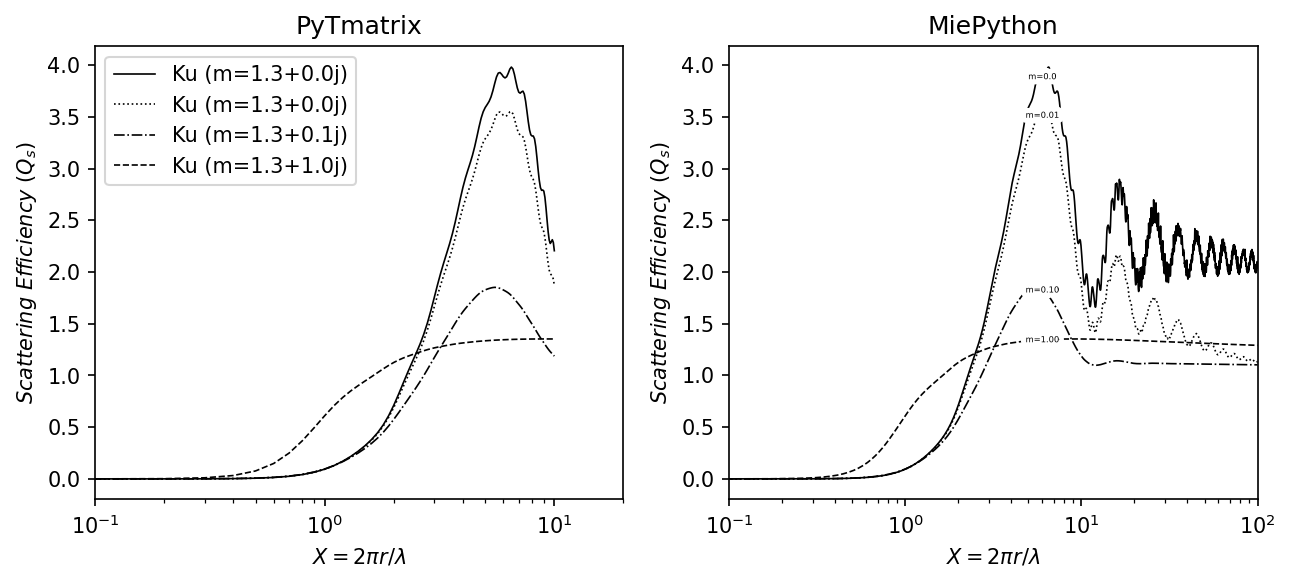

In [8]:
fig, (ax, ax1) = plt.subplots(1, 2, figsize=(10, 4), dpi=150)
#PyTmatrix
ax.plot(x_ku, qs_ku_dask_C0, label=f'Ku (m={m_ku0:.1f})', c="k", lw=0.8)
ax.plot(x_ku, qs_ku_C1, label=f'Ku (m={m_ku1:.1f})', c="k", lw=0.8, ls=':')
ax.plot(x_ka, qs_ka_C2, label=f'Ku (m={m_ku2:.1f})', c="k", lw=0.8, ls='-.')
ax.plot(x_ka, qs_ka_C3, label=f'Ku (m={m_ku3:.1f})', c="k", lw=0.8, ls='--')
ax.set_xscale('log')
ax.set_ylabel(r'$Scattering \  Efficiency \ (Q_s)$')
ax.set_xlabel(r'$X = 2\pi r / \lambda$')
ax.legend()
ax.set_xscale('log')
ax.set_xlim(0.1, 20)
ax.set_title("PyTmatrix")

#MiePython
ax1.plot(x_mie, qsca_1, c="k", lw=0.8, label=f'm={m[0].imag:.1f}')
ax1.plot(x_mie, qsca_2, c="k", lw=0.8, ls=':', label=f'm={m[1].imag:.2f}')
ax1.plot(x_mie, qsca_3, c="k", lw=0.8, ls='-.', label=f'm={m[2].imag:.2f}')
ax1.plot(x_mie, qsca_4, c="k", lw=0.8, ls='--', label=f'm={m[3].imag:.2f}')
ax1.set_xscale('log')
ax1.set_xlim(0.1, 100)
# ax.legend(fontsize=7)
_ = labelLines(fig.gca().get_lines(), color='k', fontsize=4, align=False, xvals=(6, 6))
ax1.set_ylabel(r'$Scattering \  Efficiency \ (Q_s)$')
ax1.set_xlabel(r'$X = 2\pi r / \lambda$')
ax1.set_title("MiePython")

Text(0.5, 0, '$X = 2\\pi r / \\lambda$')

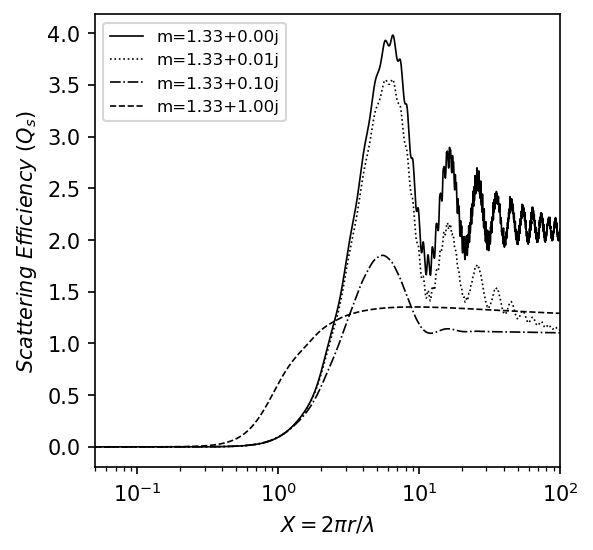

In [9]:
#MiePython
fig, ax1 = plt.subplots(figsize=(4, 4), dpi=150)
ax1.plot(x_mie, qsca_1, c="k", lw=0.8, label=f'm={m[0]:.2f}')
ax1.plot(x_mie, qsca_2, c="k", lw=0.8, ls=':', label=f'm={m[1]:.2f}')
ax1.plot(x_mie, qsca_3, c="k", lw=0.8, ls='-.', label=f'm={m[2]:.2f}')
ax1.plot(x_mie, qsca_4, c="k", lw=0.8, ls='--', label=f'm={m[3]:.2f}')
ax1.set_xscale('log')
ax1.set_xlim(0.05, 100)
ax1.legend(fontsize=8)
# _ = labelLines(fig.gca().get_lines(), color='k', fontsize=4, align=False, xvals=(6, 6))
ax1.set_ylabel(r'$Scattering \  Efficiency \ (Q_s)$')
ax1.set_xlabel(r'$X = 2\pi r / \lambda$')
# ax1.set_title("MiePython")

Text(0.5, 0, '$X = 2\\pi r / \\lambda$')

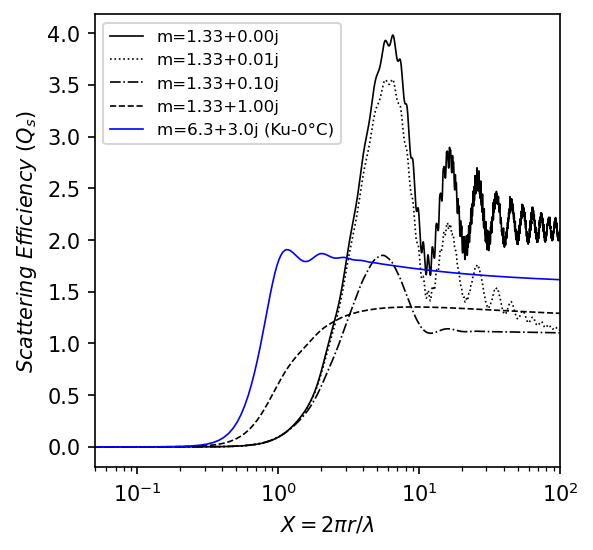

In [10]:
#MiePython
fig, ax1 = plt.subplots(figsize=(4, 4), dpi=150)
ax1.plot(x_mie, qsca_1, c="k", lw=0.8, label=f'm={m[0]:.2f}')
ax1.plot(x_mie, qsca_2, c="k", lw=0.8, ls=':', label=f'm={m[1]:.2f}')
ax1.plot(x_mie, qsca_3, c="k", lw=0.8, ls='-.', label=f'm={m[2]:.2f}')
ax1.plot(x_mie, qsca_4, c="k", lw=0.8, ls='--', label=f'm={m[3]:.2f}')
ax1.plot(x_mie, qsca_5, c="blue", lw=0.8, label=f'm={m[4]:.1f} (Ku-0°C)')
# ax1.plot(x_mie, qsca_6, c="red", lw=0.8, label=f'm={m[5]:.1f} (Ka-0°C)')

ax1.set_xscale('log')
ax1.set_xlim(0.05, 100)
ax1.legend(fontsize=8)
# _ = labelLines(fig.gca().get_lines(), color='k', fontsize=4, align=False, xvals=(6, 6))
ax1.set_ylabel(r'$Scattering \  Efficiency \ (Q_s)$')
ax1.set_xlabel(r'$X = 2\pi r / \lambda$')

Text(0.5, 0, '$X = 2\\pi r / \\lambda$')

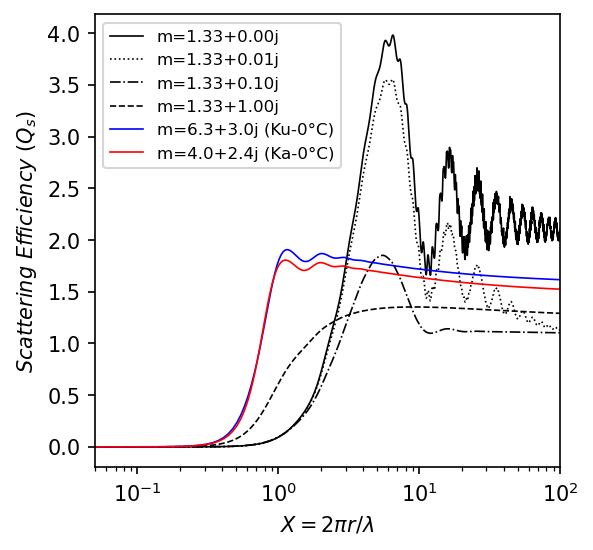

In [11]:
#MiePython
fig, ax1 = plt.subplots(figsize=(4, 4), dpi=150)
ax1.plot(x_mie, qsca_1, c="k", lw=0.8, label=f'm={m[0]:.2f}')
ax1.plot(x_mie, qsca_2, c="k", lw=0.8, ls=':', label=f'm={m[1]:.2f}')
ax1.plot(x_mie, qsca_3, c="k", lw=0.8, ls='-.', label=f'm={m[2]:.2f}')
ax1.plot(x_mie, qsca_4, c="k", lw=0.8, ls='--', label=f'm={m[3]:.2f}')
ax1.plot(x_mie, qsca_5, c="blue", lw=0.8, label=f'm={m[4]:.1f} (Ku-0°C)')
ax1.plot(x_mie, qsca_6, c="red", lw=0.8, label=f'm={m[5]:.1f} (Ka-0°C)')
# ax1.axvline(x=x1, ymin=0, ymax=3)
ax1.set_xscale('log')
ax1.set_xlim(0.05, 100)
ax1.legend(fontsize=8)
# _ = labelLines(fig.gca().get_lines(), color='k', fontsize=4, align=False, xvals=(6, 6))
ax1.set_ylabel(r'$Scattering \  Efficiency \ (Q_s)$')
ax1.set_xlabel(r'$X = 2\pi r / \lambda$')

Text(0.5, 1.0, 'MiePython')

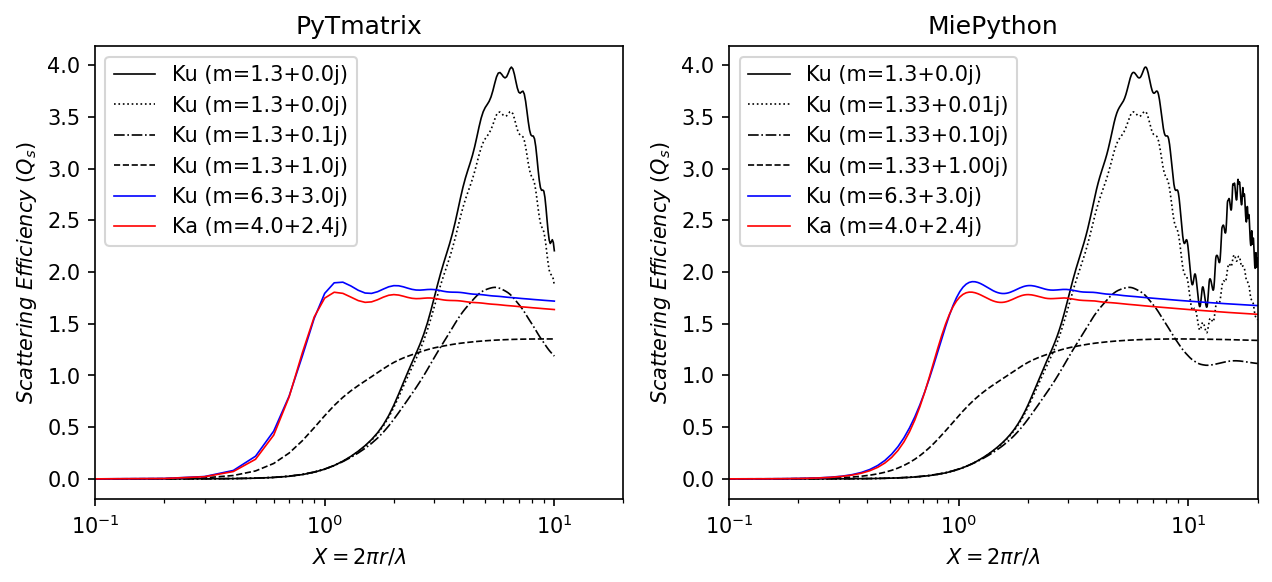

In [12]:
fig, (ax, ax1) = plt.subplots(1, 2, figsize=(10, 4), dpi=150)
#PyTmatrix
ax.plot(x_ku, qs_ku_dask_C0, label=f'Ku (m={m_ku0:.1f})', c="k", lw=0.8)
ax.plot(x_ku, qs_ku_C1, label=f'Ku (m={m_ku1:.1f})', c="k", lw=0.8, ls=':')
ax.plot(x_ka, qs_ka_C2, label=f'Ku (m={m_ku2:.1f})', c="k", lw=0.8, ls='-.')
ax.plot(x_ka, qs_ka_C3, label=f'Ku (m={m_ku3:.1f})', c="k", lw=0.8, ls='--')
ax.plot(x_ku_1, qs_ku_dask, label=f'Ku (m={m_ku:.1f})', c="blue", lw=0.8,)
ax.plot(x_ka_1, qs_ka_dask, label=f'Ka (m={m_ka:.1f})', c="red", lw=0.8,)
ax.set_xscale('log')
ax.set_ylabel(r'$Scattering \  Efficiency \ (Q_s)$')
ax.set_xlabel(r'$X = 2\pi r / \lambda$')
ax.legend()
ax.set_xscale('log')
ax.set_xlim(0.1, 20)
ax.set_title("PyTmatrix")

#MiePython
ax1.plot(x_mie, qsca_1, c="k", lw=0.8, label=f'Ku (m={m[0]:.1f})')
ax1.plot(x_mie, qsca_2, c="k", lw=0.8, ls=':', label=f'Ku (m={m[1]:.2f})')
ax1.plot(x_mie, qsca_3, c="k", lw=0.8, ls='-.', label=f'Ku (m={m[2]:.2f})')
ax1.plot(x_mie, qsca_4, c="k", lw=0.8, ls='--', label=f'Ku (m={m[3]:.2f})')
ax1.plot(x_mie, qsca_5, c="blue", lw=0.8, label=f'Ku (m={m[4]:.1f})')
ax1.plot(x_mie, qsca_6, c="red", lw=0.8, label=f'Ka (m={m[5]:.1f})')

ax1.set_xscale('log')
ax1.set_xlim(0.1, 20)
# ax.legend(fontsize=7)
# _ = labelLines(fig.gca().get_lines(), color='k', fontsize=4, align=False, xvals=(6, 6))
ax1.set_ylabel(r'$Scattering \  Efficiency \ (Q_s)$')
ax1.set_xlabel(r'$X = 2\pi r / \lambda$')
ax1.legend()
ax1.set_title("MiePython")

### Scattering phase function

In [13]:
%%time
phase_ku = np.array(phase_dask(d, wl="Ku", m=complex(1.33), _dask=False))
phase_ku.shape

CPU times: user 2min 10s, sys: 461 ms, total: 2min 10s
Wall time: 2min 10s


(100, 180)

In [14]:
x = np.linspace(0.1, 10, 100) # mm
m_test = 1.33
theta = np.linspace(0, 180, 1800)
mu = np.cos(theta / 180 *  np.pi)
phase = []
for i in x:
    phase.append(miepython.i_unpolarized(m_test,i,mu, norm='one'))

Text(0.5, 1.0, 'MiePython')

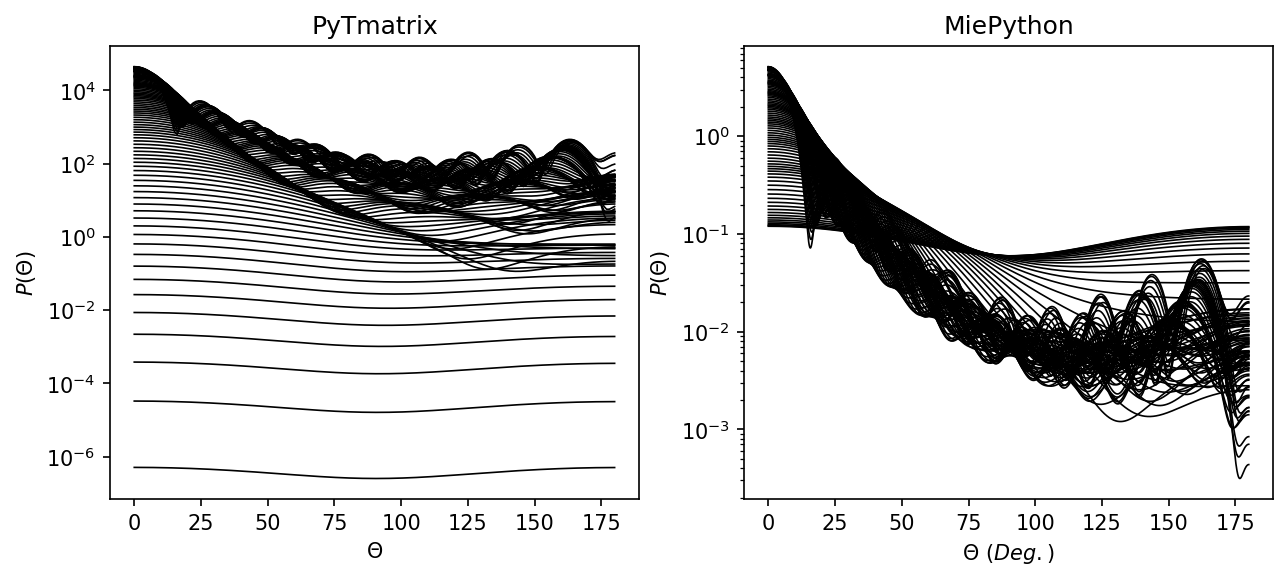

In [15]:
fig, (ax, ax1) = plt.subplots(1, 2, figsize=(10, 4), dpi=150)
for i in range(phase_ku.shape[0]):
    ax.plot(np.linspace(0, 180, 180), phase_ku[i, :], c="k", lw=0.8, label=f'X={x[i]}')
ax.set_ylabel(r'$P(\Theta)$')
ax.set_xlabel(r'$\Theta$')
ax.set_yscale('log')
ax.set_title("PyTmatrix")
# labelLines(fig.gca().get_lines(), color='k', fontsize=4, align=False, xvals=(10, 10))

for idx, j in enumerate(phase):
    ax1.plot(theta, j, label=f'$X={x[idx]:.1f}$', c='k', lw=0.8)
ax1.set_yscale('log')
# ax1.set_ylim(0.001, 1e9)
#_ = labelLines(fig.gca().get_lines(), color='k', fontsize=5 , align=False)
ax1.set_ylabel(r'$P(\Theta)$')
ax1.set_xlabel(r'$\Theta \ (Deg.)$')
ax1.set_title("MiePython")

In [16]:
d_p = np.linspace(0.25, 2.5, 10)
x_ku_p = size_parm(d_p, "Ku")
x_ka_p = size_parm(d_p, "Ka")
print(d_p.shape[0])
offset = [0.0009, 0.005, 0.01, 0.05, 0.1, 0.5, 0.8, 1.1, 1.5, 2]

10


Text(0.5, 1.0, '$Ku-band$')

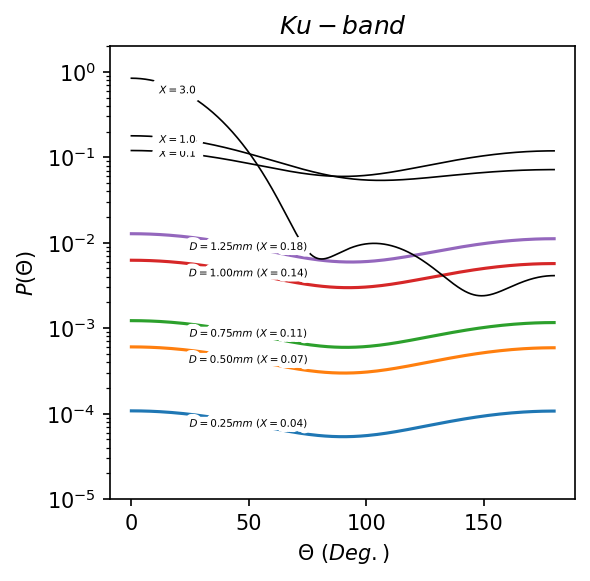

In [17]:
theta = np.linspace(0,180,180)
mu = np.cos(theta/180*np.pi)
phase = []
for i in x_ku_p:
    phase.append(miepython.i_unpolarized(m_mie[-2],i,mu, norm='one'))


fig, ax = plt.subplots(figsize=(4,4), dpi=150)
# for idx, p in enumerate(phase):
ax.plot(theta, phase[0] * offset[0], label=f'$D={d_p[0]:.2f}mm \  (X={x_ku_p[0]:.2f})$')
ax.plot(theta, phase[1] * offset[1], label=f'$D={d_p[1]:.2f}mm \  (X={x_ku_p[1]:.2f})$')
ax.plot(theta, phase[2] * offset[2], label=f'$D={d_p[2]:.2f}mm \  (X={x_ku_p[2]:.2f})$')
ax.plot(theta, phase[3] * offset[3], label=f'$D={d_p[3]:.2f}mm \  (X={x_ku_p[3]:.2f})$')
ax.plot(theta, phase[4] * offset[4], label=f'$D={d_p[4]:.2f}mm \  (X={x_ku_p[4]:.2f})$')
ax.plot(theta, phase_ku[-1] * offset[5], label=f'$D={d_p[-1]:.2f}mm \  (X={x_ku_p[-1]:.2f})$')


m = 1.33
x = [0.1, 1., 3]
theta = np.linspace(0, 180, 1800)
mu = np.cos(theta / 180 *  np.pi)
phase_real = []
for i in x:
    phase_real.append(miepython.i_unpolarized(m,i,mu))

for idx, j in enumerate(phase_real):
    ax.plot(theta, j, label=f'$X={x[idx]:.1f}$', c='k', lw=0.8)
    
ax.set_yscale('log')
lbln = fig.gca().get_lines()
_ = labelLines(lbln[:-3], color='k', fontsize=5
               , align=False, xvals=(50, 50))


labelLine(lbln[-3], color='k', fontsize=5, align=False, x=20)
labelLine(lbln[-2], color='k', fontsize=5, align=False, x=20)
labelLine(lbln[-1], color='k', fontsize=5, align=False, x=20)
ax.set_ylabel(r'$P(\Theta)$')
ax.set_xlabel(r'$\Theta \ (Deg.)$')
ax.set_ylim(0.00001, 2)
ax.set_yscale('log')
ax.set_title('$Ku-band$')

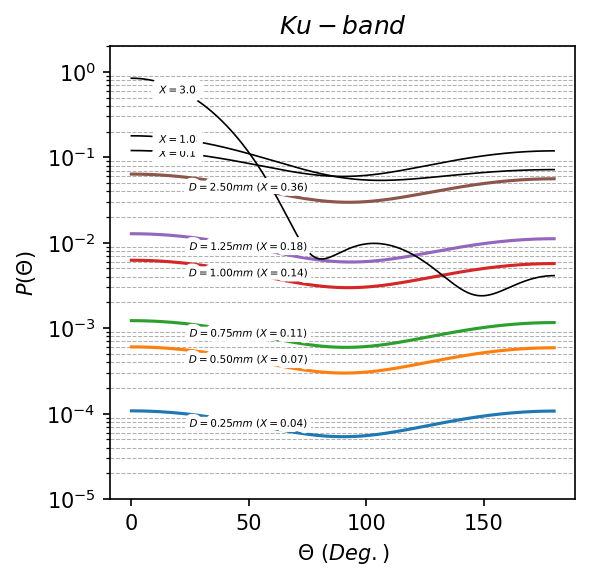

In [18]:
theta = np.linspace(0,180,180)
mu = np.cos(theta/180*np.pi)
phase_ku = []
for i in x_ku_p:
    phase_ku.append(miepython.i_unpolarized(m_mie[-2],i,mu, norm='one'))


fig, ax = plt.subplots(figsize=(4,4), dpi=150)
# for idx, p in enumerate(phase):
ax.plot(theta, phase_ku[0] * offset[0], label=f'$D={d_p[0]:.2f}mm \  (X={x_ku_p[0]:.2f})$')
ax.plot(theta, phase_ku[1] * offset[1], label=f'$D={d_p[1]:.2f}mm \  (X={x_ku_p[1]:.2f})$')
ax.plot(theta, phase_ku[2] * offset[2], label=f'$D={d_p[2]:.2f}mm \  (X={x_ku_p[2]:.2f})$')
ax.plot(theta, phase_ku[3] * offset[3], label=f'$D={d_p[3]:.2f}mm \  (X={x_ku_p[3]:.2f})$')
ax.plot(theta, phase_ku[4] * offset[4], label=f'$D={d_p[4]:.2f}mm \  (X={x_ku_p[4]:.2f})$')
ax.plot(theta, phase_ku[-1] * offset[5], label=f'$D={d_p[-1]:.2f}mm \  (X={x_ku_p[-1]:.2f})$')
m = 1.33
x = [0.1, 1., 3]
theta = np.linspace(0, 180, 1800)
mu = np.cos(theta / 180 *  np.pi)
phase_real = []
for i in x:
    phase_real.append(miepython.i_unpolarized(m,i,mu))

for idx, j in enumerate(phase_real):
    ax.plot(theta, j, label=f'$X={x[idx]:.1f}$', c='k', lw=0.8)
    
ax.set_yscale('log')
lbln = fig.gca().get_lines()
_ = labelLines(lbln[:-3], color='k', fontsize=5
               , align=False, xvals=(50, 50))


labelLine(lbln[-3], color='k', fontsize=5, align=False, x=20)
labelLine(lbln[-2], color='k', fontsize=5, align=False, x=20)
labelLine(lbln[-1], color='k', fontsize=5, align=False, x=20)
ax.set_ylabel(r'$P(\Theta)$')
ax.set_xlabel(r'$\Theta \ (Deg.)$')
ax.set_ylim(0.00001, 2)
ax.set_yscale('log')
ax.set_title('$Ku-band$')
ax.grid(which='minor', lw=0.5, ls='--')

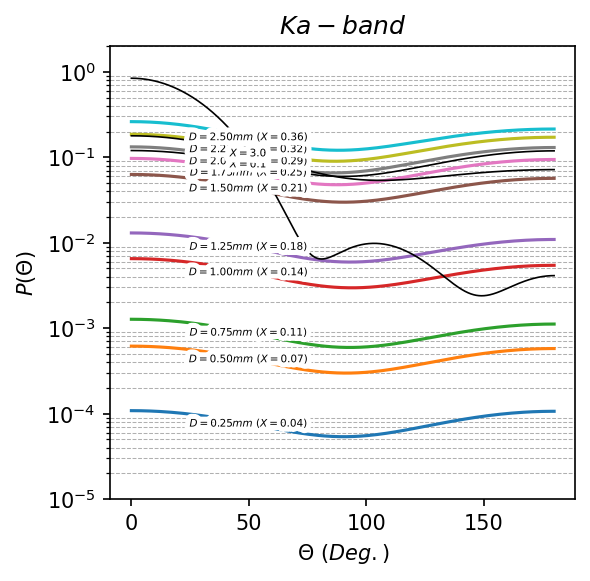

In [19]:
theta = np.linspace(0,180,180)
mu = np.cos(theta/180*np.pi)
phase_ka = []
for i in x_ka_p:
    phase_ka.append(miepython.i_unpolarized(m_mie[-1],i,mu, norm='one'))


fig, ax = plt.subplots(figsize=(4,4), dpi=150)
for idx, p in enumerate(phase):
    ax.plot(theta, phase_ka[idx] * offset[idx], label=f'$D={d_p[idx]:.2f}mm \  (X={x_ku_p[idx]:.2f})$')
m = 1.33
x = [0.1, 1., 3]
theta = np.linspace(0, 180, 1800)
mu = np.cos(theta / 180 *  np.pi)
phase_real = []
for i in x:
    phase_real.append(miepython.i_unpolarized(m,i,mu))

for idx, j in enumerate(phase_real):
    ax.plot(theta, j, label=f'$X={x[idx]:.1f}$', c='k', lw=0.8)
    
ax.set_yscale('log')
# ax1.set_ylim(0.001, 1e9)
_ = labelLines(fig.gca().get_lines(), color='k', fontsize=5
               , align=False, xvals=(50, 50))
ax.set_ylabel(r'$P(\Theta)$')
ax.set_xlabel(r'$\Theta \ (Deg.)$')
ax.set_ylim(0.00001, 2)
ax.set_yscale('log')
ax.set_title('$Ka-band$')
ax.grid(which='minor', lw=0.5, ls='--')

In [20]:
d_p = np.linspace(0.01, 2.5, 100)
x_ku_p = size_parm(d_p, "Ku")
x_ka_p = size_parm(d_p, "Ka")

phase_ku = []
for i in x_ku_p:
    phase_ku.append(miepython.i_unpolarized(m_mie[-2],i,mu, norm='one'))
    
phase_ka = []
for i in x_ka_p:
    phase_ka.append(miepython.i_unpolarized(m_mie[-1],i,mu, norm='one'))


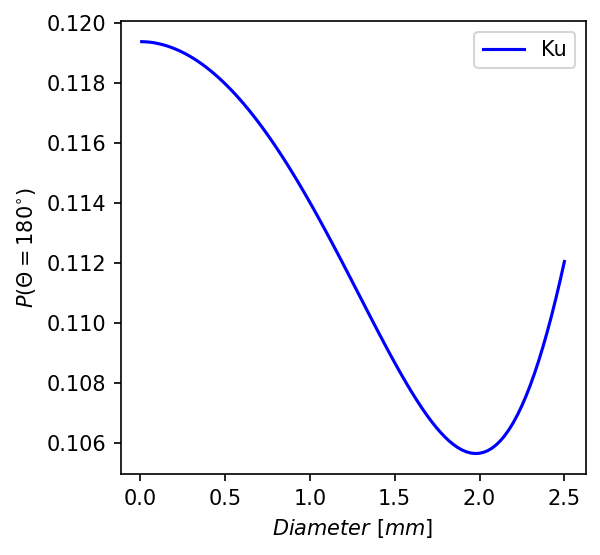

In [21]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=150)
ax.plot(d_p, np.squeeze(np.array(phase_ku))[:, -1], c='blue', label="Ku")
ax.set_xlabel("$Diameter \ [mm]$")
ax.set_ylabel("$P(\Theta = 180^{\circ})$")
ax.legend()

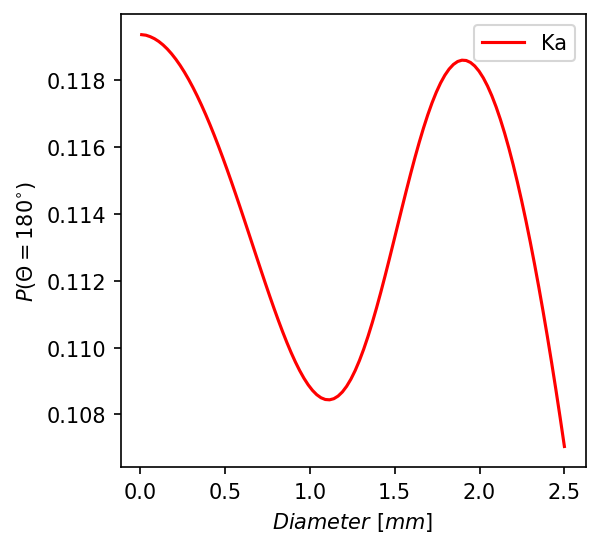

In [22]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=150)
ax.plot(d_p, np.squeeze(np.array(phase_ka))[:, -1], c='red', label="Ka")
ax.set_xlabel("$Diameter \ [mm]$")
ax.set_ylabel("$P(\Theta = 180^{\circ})$")
ax.legend()

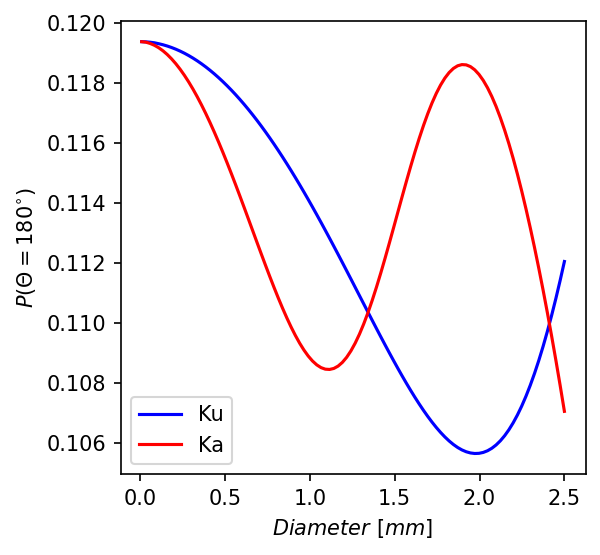

In [23]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=150)
ax.plot(d_p, np.squeeze(np.array(phase_ku))[:, -1], c='blue', label="Ku")
ax.plot(d_p, np.squeeze(np.array(phase_ka))[:, -1], c='red', label="Ka")
ax.set_xlabel("$Diameter \ [mm]$")
ax.set_ylabel("$P(\Theta = 180^{\circ})$")
ax.legend()

Text(0, 0.5, '$P(\\Theta = 180^{\\circ})_{Ku} - P(\\Theta = 180^{\\circ})_{Ka}$')

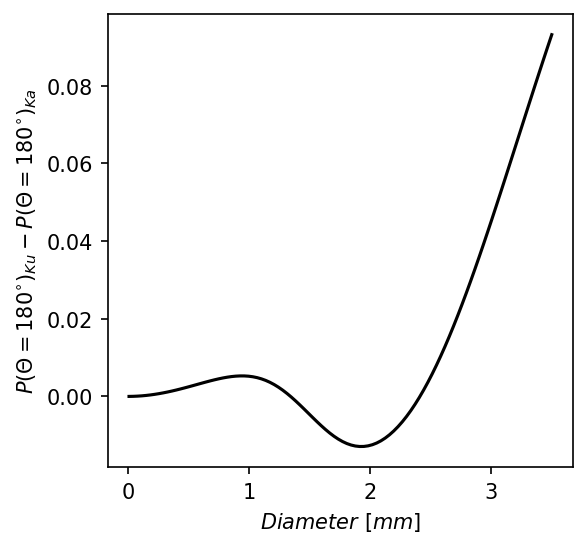

In [24]:
d_p = np.linspace(0.01, 3.5, 100)
x_ku_p = size_parm(d_p, "Ku")
x_ka_p = size_parm(d_p, "Ka")

phase_ku = []
for i in x_ku_p:
    phase_ku.append(miepython.i_unpolarized(m_mie[-2],i,mu, norm='one'))
    
phase_ka = []
for i in x_ka_p:
    phase_ka.append(miepython.i_unpolarized(m_mie[-1],i,mu, norm='one'))

fig, ax = plt.subplots(figsize=(4, 4), dpi=150)
ax.plot(d_p, np.squeeze(np.array(phase_ku))[:, -1] - np.squeeze(np.array(phase_ka))[:, -1], c='k')
ax.set_xlabel("$Diameter \ [mm]$")
ax.set_ylabel("$P(\Theta = 180^{\circ})$")
ax.set_ylabel("$P(\Theta = 180^{\circ})_{Ku} - P(\Theta = 180^{\circ})_{Ka}$")

In [25]:
m = 1.33
x = [0.1, 1., 3, 10, 30, 100, 300, 1000, 3000, 10000]
offset = [0.02, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4, 1e5, 1e7, 1e9]
theta = np.linspace(0, 180, 1800)
mu = np.cos(theta / 180 *  np.pi)
phase = []

for i in x:
    phase.append(miepython.i_unpolarized(m,i,mu, norm='one'))
    
len(phase)

10

Text(0.5, 0, '$\\Theta \\ (Deg.)$')

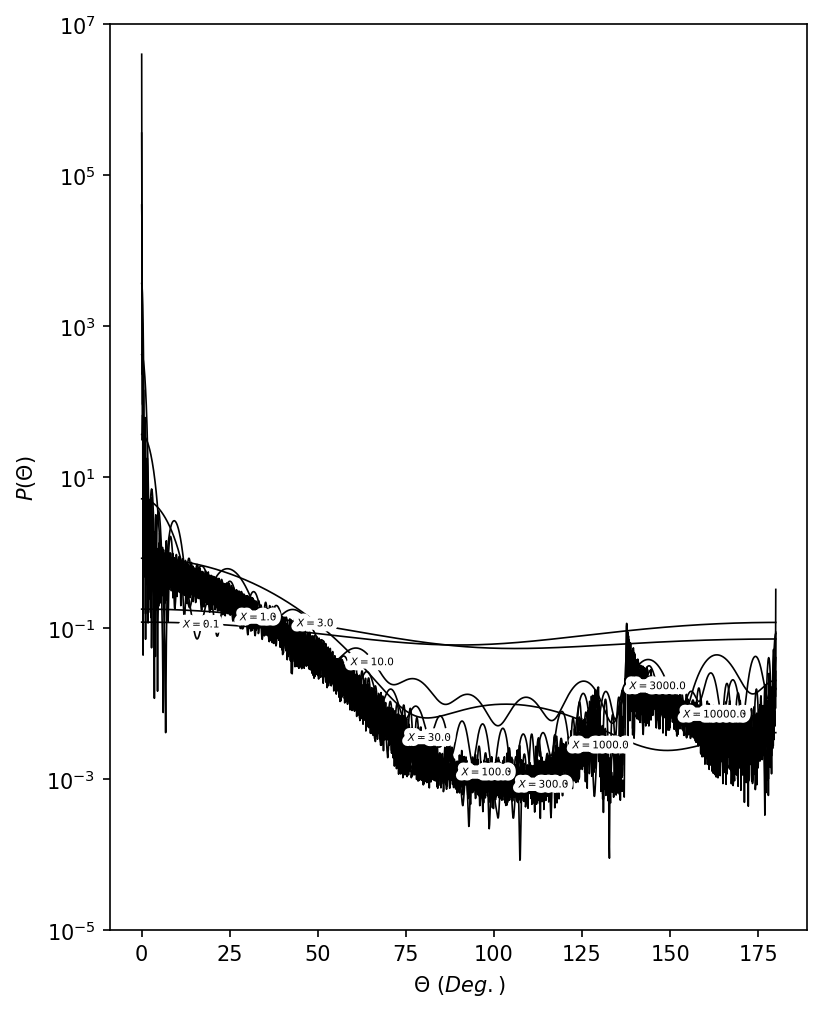

In [26]:
fig, ax1 = plt.subplots(figsize=(6,8), dpi=150)
for idx, j in enumerate(phase):
    ax1.plot(theta, j, label=f'$X={x[idx]:.1f}$', c='k', lw=0.8)
ax1.set_yscale('log')
ax1.set_ylim(0.00001, 1e7)
_ = labelLines(fig.gca().get_lines(), color='k', fontsize=5
               , align=False)
ax1.set_ylabel(r'$P(\Theta)$')
ax1.set_xlabel(r'$\Theta \ (Deg.)$')

Text(0.5, 0, '$\\Theta \\ (Deg.)$')

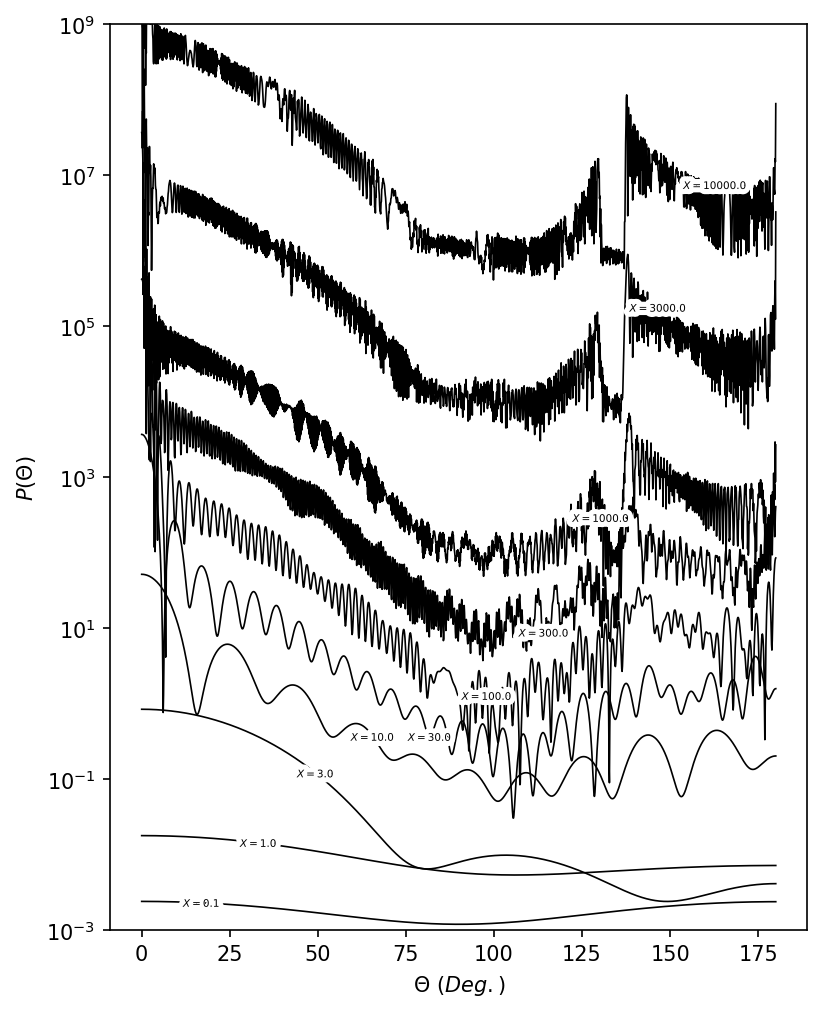

In [27]:
fig, ax1 = plt.subplots(figsize=(6,8), dpi=150)
for idx, j in enumerate(phase):
    ax1.plot(theta, j * offset[idx], label=f'$X={x[idx]:.1f}$', c='k', lw=0.8)
ax1.set_yscale('log')
ax1.set_ylim(0.001, 1e9)
_ = labelLines(fig.gca().get_lines(), color='k', fontsize=5
               , align=False)
ax1.set_ylabel(r'$P(\Theta)$')
ax1.set_xlabel(r'$\Theta \ (Deg.)$')

In [28]:
d = np.linspace(0.1, 30, 1000)
rcs_ku = radar_cs(d, wl="Ku")
rcs_ka = radar_cs(d, wl="Ka")

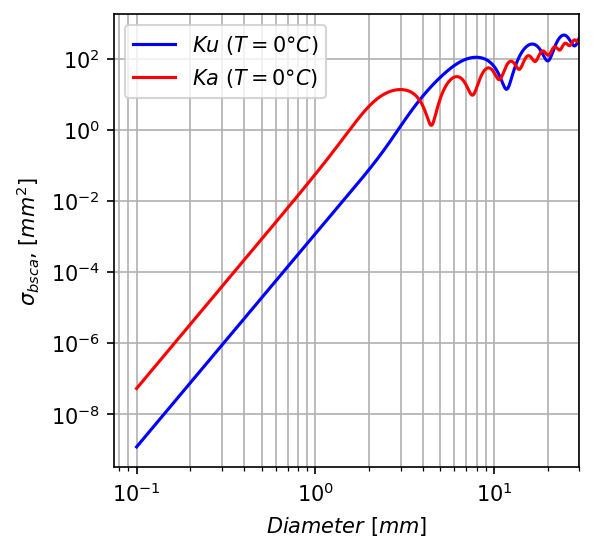

In [29]:
fig, ax = plt.subplots(figsize=(4,4), dpi=150)
ax.plot(d, rcs_ku, c='blue', label="$Ku \ (T=0\degree C)$")
ax.plot(d, rcs_ka, c='red', label="$Ka \ (T=0\degree C)$")
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim(0, 30)
ax.legend()
ax.set_ylabel(r'$\sigma_{bsca}$, [$mm^{2}$]')
ax.set_xlabel(r'$Diameter \ [mm]$')
ax.grid('both')
ax.grid(which='minor')

In [30]:
def scatt_cs(d, wl="Ku", temp=0, m=None):
    if wl == "Ku":
        wlg = tmatrix_aux.wl_Ku
        if m is None:
            if temp == 0:
                m = refractive.m_w_0C[tmatrix_aux.wl_Ku]
            elif temp == 10:
                m = refractive.m_w_10C[tmatrix_aux.wl_Ku]
            else:
                m = refractive.m_w_10C[tmatrix_aux.wl_Ku]
    elif wl == "Ka":
        wlg = tmatrix_aux.wl_Ka
        if m is None:
            if temp == 0:
                m = refractive.m_w_0C[tmatrix_aux.wl_Ka]
            elif temp == 10:
                m = refractive.m_w_10C[tmatrix_aux.wl_Ka]
            else:
                m = refractive.m_w_10C[tmatrix_aux.wl_Ka]
    elif wl == "W":
        wlg = tmatrix_aux.wl_W
        if m is None:
            if temp == 0:
                m = refractive.m_w_0C[tmatrix_aux.wl_W]
            elif temp == 10:
                m = refractive.m_w_10C[tmatrix_aux.wl_W]
            else:
                m = refractive.m_w_10C[tmatrix_aux.wl_W]
    else:
        raise Exception('wl {} not valid. Please use Ka, Ku, or W'.format(wl))
    x = size_parm(d=d, wl=wl)
    sigma = []
    for i in d:
        scat = dask.delayed(_scatterer)(i, 1, wlg, m)
        sig = dask.delayed(sca_xsect)(scat)
        sigma.append(sig)
    return np.array(dask.compute(*sigma, scheduler="processes"))

In [31]:
d = np.linspace(0.1, 30, 1000)
x_ku = size_parm(d, "Ku")
x_ka = size_parm(d, "Ka")

In [32]:
cs_ku = scatt_cs(d, wl="Ku")
cs_ka = scatt_cs(d, wl="Ka")

Text(0.5, 0, '$Diameter \\ [mm]$')

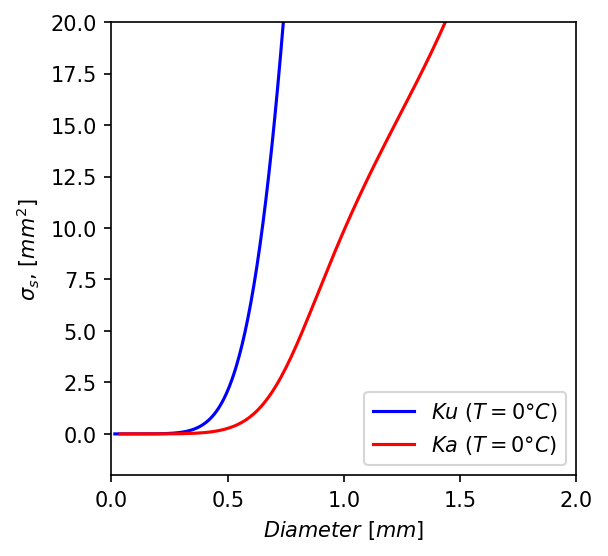

In [33]:
fig, ax = plt.subplots(figsize=(4,4), dpi=150)
# ax.plot(d, cs_ku, c='blue', label="$Ku \ (T=0\degree C)$")
# ax.plot(d, cs_ka, c='red', label="$Ka \ (T=0\degree C)$")
ax.plot(x_ku, cs_ku, c='blue', label="$Ku \ (T=0\degree C)$")
ax.plot(x_ka, cs_ka, c='red', label="$Ka \ (T=0\degree C)$")
# ax.set_yscale('log')
# ax.set_xscale('log')
ax.set_xlim(0, 2)
ax.set_ylim(-2, 20)
ax.legend()
ax.set_ylabel(r'$\sigma_{s}$, [$mm^{2}$]')
ax.set_xlabel(r'$Diameter \ [mm]$')

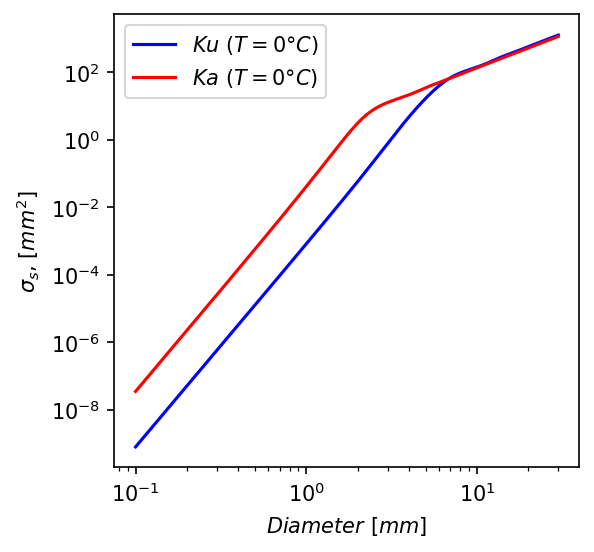

In [34]:
fig, ax = plt.subplots(figsize=(4,4), dpi=150)
ax.plot(d, cs_ku, c='blue', label="$Ku \ (T=0\degree C)$")
ax.plot(d, cs_ka, c='red', label="$Ka \ (T=0\degree C)$")
# ax.set_xlim(0, 30)
ax.legend()
ax.set_ylabel(r'$\sigma_{s}$, [$mm^{2}$]')
ax.set_xlabel(r'$Diameter \ [mm]$')
# axins = ax.inset_axes([0.5, 0.5, 0.47, 0.47])
# axins.plot(d, rcs_ku, c='blue', label="$Ku \ (T=0\degree C)$")
# axins.plot(d, rcs_ka, c='red', label="$Ka \ (T=0\degree C)$")
# axins.set_xlim(1, 8)
# axins.set_ylim(-5, 80)
# axins.set_xticklabels("")
# axins.set_yticklabels("")
# ax.indicate_inset_zoom(axins)
ax.set_yscale('log')
ax.set_xscale('log')

In [35]:
rcs_ku = scatt_cs(d, wl="Ku") / (np.pi * (d/2) ** 2 )
rcs_ka = scatt_cs(d, wl="Ka")/ (np.pi * (d/2) ** 2 )

Text(0.5, 0, '$Diameter \\ [mm]$')

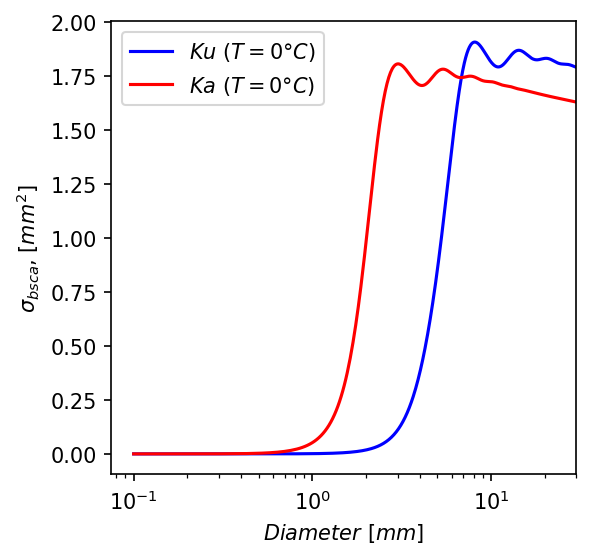

In [36]:
fig, ax = plt.subplots(figsize=(4,4), dpi=150)
ax.plot(d, rcs_ku, c='blue', label="$Ku \ (T=0\degree C)$")
ax.plot(d, rcs_ka, c='red', label="$Ka \ (T=0\degree C)$")
# ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim(0, 30)
ax.legend()
ax.set_ylabel(r'$\sigma_{bsca}$, [$mm^{2}$]')
ax.set_xlabel(r'$Diameter \ [mm]$')

In [37]:
def norm_gamma(d, nw, mu, dm):
    f_mu = (6 * (4 + mu) ** (mu + 4)) / (4 ** 4 * gamma(mu + 4) )
    slope = (4 + mu) / dm
    return nw * f_mu * (d / dm) ** mu * np.exp(-slope * d)

In [38]:
d = np.linspace(0.1, 3, 100)
ng = []
_mu = np.array([-3.5, 0.5, 1., 3.])
for i in _mu:
    ng.append(norm_gamma(d, nw=1, mu=i, dm=1))
ng = np.array(ng)
ng.shape

(4, 100)

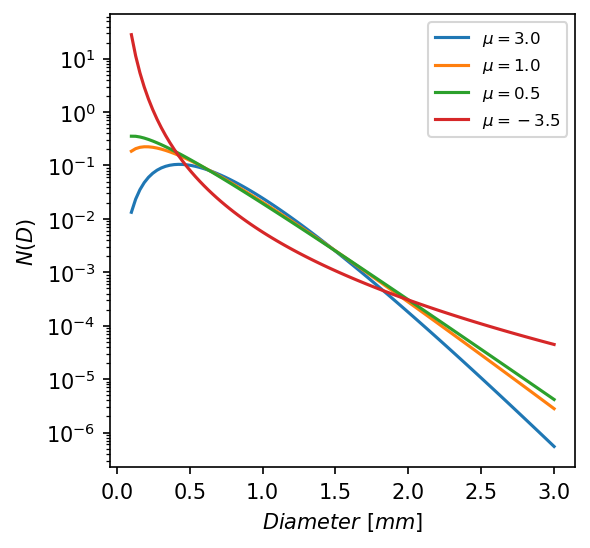

In [39]:
fig, ax = plt.subplots(figsize=(4,4), dpi=150)

ax.plot(d, ng[3, :], label=f'$\mu={_mu[3]:.1f}$', c='C0')
ax.plot(d, ng[2, :], label=f'$\mu={_mu[2]:.1f}$', c='C1')
ax.plot(d, ng[1, :], label=f'$\mu={_mu[1]:.1f}$', c='C2')
ax.plot(d, ng[0, :], label=f'$\mu={_mu[0]:.1f}$', c='C3')
ax.set_yscale('log')
    
ax.set_xlabel('$Diameter \ [mm]$')
ax.set_ylabel('$N(D)$')
ax.legend(fontsize=8)

In [65]:
sct_ku = tmatrix.Scatterer(radius=1.0, 
                           wavelength=tmatrix_aux.wl_Ku, 
                           m= refractive.m_w_0C[tmatrix_aux.wl_Ku], 
                           axis_ratio=1.0)

sct_ka = tmatrix.Scatterer(radius=1.0, 
                           wavelength=tmatrix_aux.wl_Ka, 
                           m=refractive.m_w_0C[tmatrix_aux.wl_Ka], 
                           axis_ratio=1.0)

dbz_ku = 10*np.log10(refl(sct_ku))
dbz_ka = 10*np.log10(refl(sct_ka))

In [66]:
def ref_wl(d):
    sct_ku = tmatrix.Scatterer(radius=d / 2 , 
                           wavelength=tmatrix_aux.wl_Ku, 
                           m= refractive.m_w_0C[tmatrix_aux.wl_Ku], 
                           axis_ratio=1.0)

    sct_ka = tmatrix.Scatterer(radius=d / 2, 
                               wavelength=tmatrix_aux.wl_Ka, 
                               m=refractive.m_w_0C[tmatrix_aux.wl_Ka], 
                               axis_ratio=1.0)

    return [10 * np.log10(refl(sct_ku)), 10 * np.log10(refl(sct_ka))]
    

In [67]:
d = np.linspace(0.1, 10, 100)

In [68]:
res = np.array([ref_wl(i) for i in d])

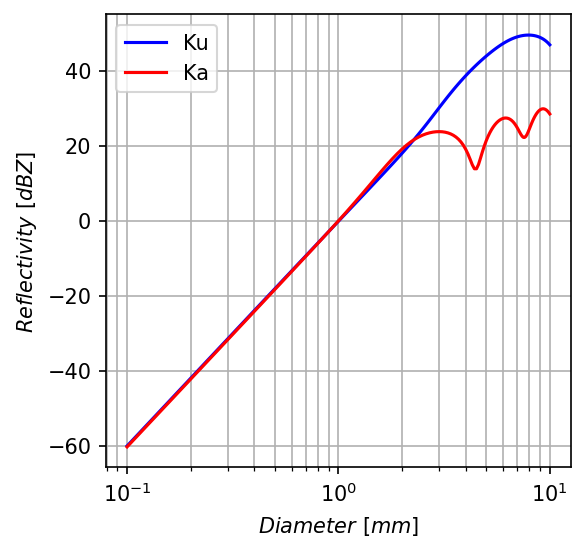

In [69]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=150)
ax.plot(d, res[:, 0], label='Ku', c='blue')
ax.plot(d, res[:, 1], label='Ka', c='red')
ax.set_xscale('log')
ax.set_ylabel('$Reflectivity \ [dBZ]$')
ax.set_xlabel('$Diameter \ [mm]$')
ax.legend()
ax.grid('both')
ax.grid(which='minor')

(0.0, 5.0)

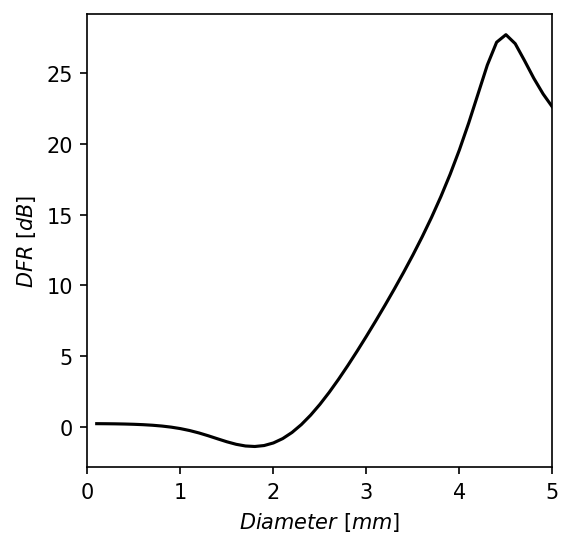

In [45]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=150)
ax.plot(d, res[:, 0] - res[:, 1], c='k')
ax.set_xlabel('$Diameter \ [mm]$')
ax.set_ylabel('$DFR \ [dB]$')
ax.set_xlim(0, 5)
# ax.set_xscale('log')

In [46]:
d = np.linspace(0.01, 3., 100)

In [47]:
x_ku = size_parm(d, "Ku")
x_ka = size_parm(d, "Ka")

In [48]:
p_ku = []
p_ka = []
for i in range(len(x_ku)):
    p_ku.append(miepython.i_unpolarized(m_mie[-2],x_ku[i],mu))
    p_ka.append(miepython.i_unpolarized(m_mie[-1],x_ka[i],mu))
p_ku = np.array(p_ku)
p_ka = np.array(p_ka)

In [49]:
p_ku.shape

(100, 1800)

In [50]:
p_ku = []
p_ka = []
for i in range(len(x_ku)):
    p_ku.append(miepython.i_unpolarized(m_mie[-2],x_ku[i],mu, norm='one'))
    p_ka.append(miepython.i_unpolarized(m_mie[-1],x_ka[i],mu, norm='one'))
p_ku = np.array(p_ku)
p_ka = np.array(p_ka)

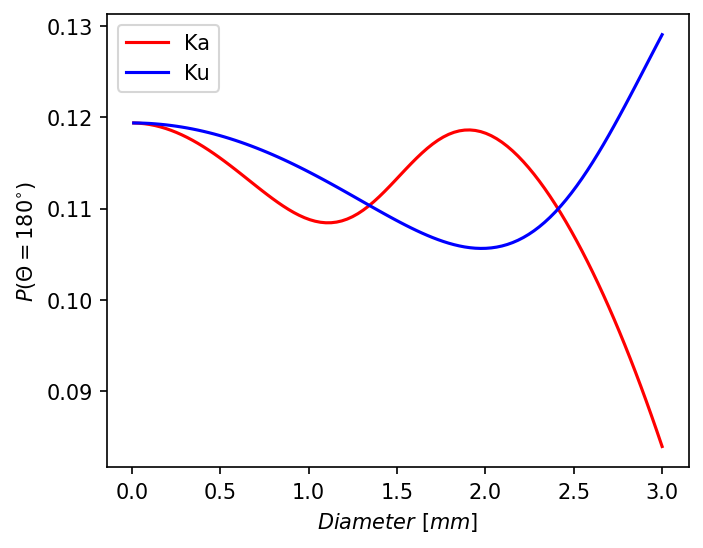

In [51]:
fig, ax = plt.subplots(figsize=(5, 4), dpi=150)
ax.plot(d, p_ka[:, -1], c='red', label="Ka")
ax.plot(d, p_ku[:, -1], c='blue', label="Ku")
ax.set_xlabel("$Diameter \ [mm]$")
ax.set_ylabel("$P(\Theta = 180^{\circ})$")
ax.legend()

Text(0, 0.5, '$P(\\Theta = 180^{\\circ})_{Ku} - P(\\Theta = 180^{\\circ})_{Ka}$')

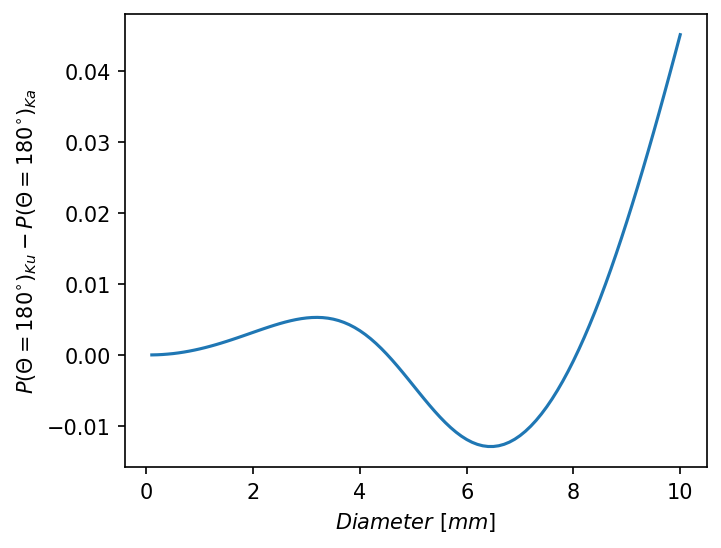

In [70]:
fig, ax = plt.subplots(figsize=(5, 4), dpi=150)
ax.plot(d, p_ku[:, -1] -  p_ka[:, -1])
ax.set_xlabel("$Diameter \ [mm]$")
ax.set_ylabel("$P(\Theta = 180^{\circ})_{Ku} - P(\Theta = 180^{\circ})_{Ka}$")


In [123]:
def ref_ray(d, wl="Ku", m=None, temp=0):
    if wl == "Ku":
        wlg = tmatrix_aux.wl_Ku
        if m is None:
            if temp == 0:
                m = refractive.m_w_0C[tmatrix_aux.wl_Ku]
            elif temp == 10:
                m = refractive.m_w_10C[tmatrix_aux.wl_Ku]
            else:
                m = refractive.m_w_10C[tmatrix_aux.wl_Ku]
    elif wl == "Ka":
        wlg = tmatrix_aux.wl_Ka
        if m is None:
            if temp == 0:
                m = refractive.m_w_0C[tmatrix_aux.wl_Ka]
            elif temp == 10:
                m = refractive.m_w_10C[tmatrix_aux.wl_Ka]
            else:
                m = refractive.m_w_10C[tmatrix_aux.wl_Ka]
    elif wl == "W":
        wlg = tmatrix_aux.wl_W
        if m is None:
            if temp == 0:
                m = refractive.m_w_0C[tmatrix_aux.wl_W]
            elif temp == 10:
                m = refractive.m_w_10C[tmatrix_aux.wl_W]
            else:
                m = refractive.m_w_10C[tmatrix_aux.wl_W]
    else:
        raise Exception('wl {} not valid. Please use Ka, Ku, or W'.format(wl))
    return 10 * np.log10(((np.pi ** 5 * 0.93) / (wlg ** 4)) * d ** 6 )

In [127]:
d = np.linspace(0.1, 10, 100)
ref_ku = 10 * np.log10(d**6)

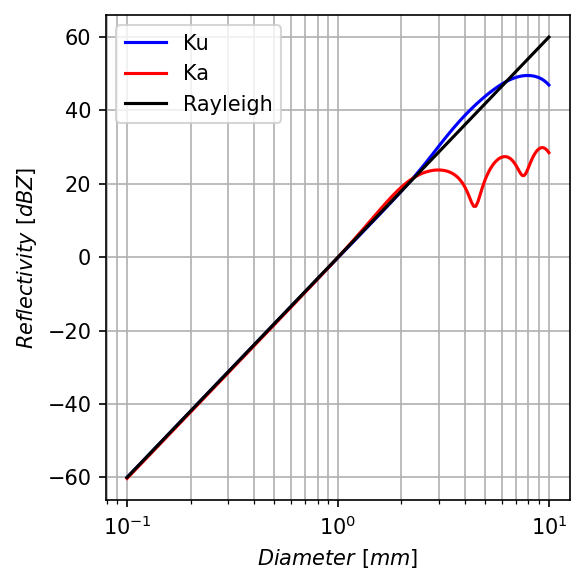

In [129]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=150)
ax.plot(d, res[:, 0], label='Ku', c='blue')
ax.plot(d, res[:, 1], label='Ka', c='red')
ax.plot(d, ref_ku, label='Rayleigh', c='k')


# ax.plot(d, ref_ka, label='Ka', c='g')
ax.set_xscale('log')
ax.set_ylabel('$Reflectivity \ [dBZ]$')
ax.set_xlabel('$Diameter \ [mm]$')
ax.legend()
ax.grid('both')
ax.grid(which='minor')
plt.tight_layout()
plt.savefig('../results/ref.jpeg')

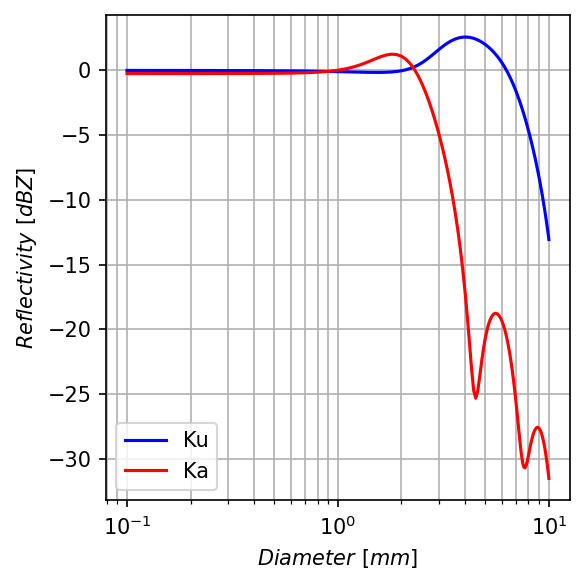

In [130]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=150)
ax.plot(d, res[:, 0] - ref_ku, label='Ku', c='blue')
ax.plot(d, res[:, 1] - ref_ku, label='Ka', c='red')
# ax.plot(d, ref_ku, label='Ku', c='k')
# ax.plot(d, ref_ka, label='Ka', c='g')
ax.set_xscale('log')
ax.set_ylabel('$Reflectivity \ [dBZ]$')
ax.set_xlabel('$Diameter \ [mm]$')
ax.legend()
ax.grid('both')
ax.grid(which='minor')
plt.tight_layout()
plt.savefig('../results/ref_diff.jpeg')